In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
#константы

IMAGE_SIZE = 256
BATCH_SIZE  = 32
CHANNELS = 3
EPOCH = 25

In [4]:
#создание датасета

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data/training',
    seed=42,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


2025-02-26 20:22:28.033714: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
#количество батчей

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 1 2 0 0 1 1 1 1 0 0 1 1 0 0 2 0 0 1 0 0 0 1 0 0 1 0 2 2 0]


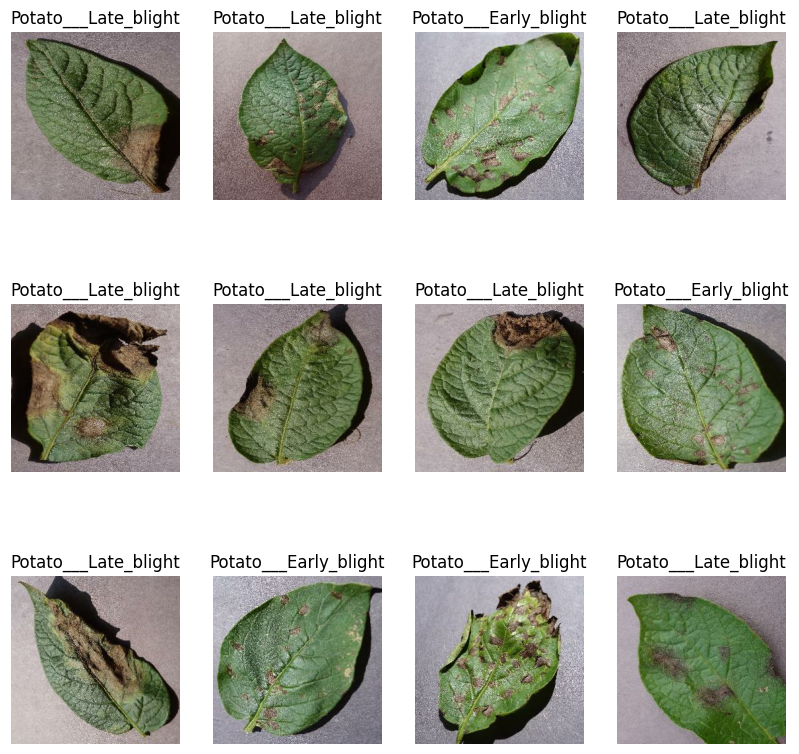

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [8]:
#size train_ds
68 * 0.8

54.400000000000006

In [9]:
#split datasets train =80%, test=10%, val=10%

train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
#split dataset

def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds    

In [14]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [16]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #for GPU

train_ds = train_ds.cache().shuffle(1000)
val_ds = val_ds.cache().shuffle(1000)
test_ds = test_ds.cache().shuffle(1000)

In [18]:
#NN

input_shape = [IMAGE_SIZE, IMAGE_SIZE, CHANNELS]
n_classes = 3

model = models.Sequential([
    layers.Input(input_shape),
    layers.Rescaling(1. / 255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_ds, 
                    epochs=EPOCH, 
                    batch_size=BATCH_SIZE, 
                    verbose=1,
                    validation_data=val_ds
                    )

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.4747 - loss: 0.9511 - val_accuracy: 0.4740 - val_loss: 0.8382
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.5455 - loss: 0.8534 - val_accuracy: 0.8385 - val_loss: 0.5741
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.7805 - loss: 0.5813 - val_accuracy: 0.8542 - val_loss: 0.3810
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.8578 - loss: 0.3890 - val_accuracy: 0.8958 - val_loss: 0.2743
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.9103 - loss: 0.2518 - val_accuracy: 0.9115 - val_loss: 0.1788
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9306 - loss: 0.1740 - val_accuracy: 0.8646 - val_loss: 0.2820
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9207 - loss: 0.2002 - val_accuracy: 0.9531 - val_loss: 0.1172
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9513 - loss: 0.1280 - val_accu

In [22]:
#model.save('data/model_potatos_val_25.keras')

In [23]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9901 - loss: 0.0281


[0.03636651486158371, 0.98828125]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

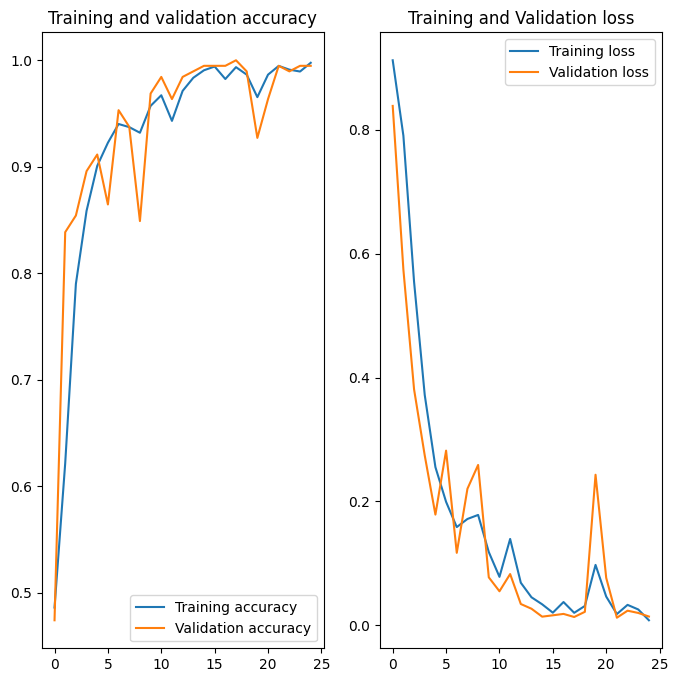

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label = 'Training accuracy')
plt.plot(range(EPOCH), val_acc, label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training loss')
plt.plot(range(EPOCH), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

первое изображение для предсказания
предсказываемое изображение: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
предсказанная метка: Potato___Late_blight


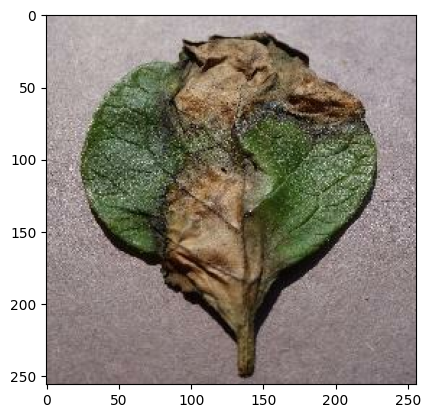

In [27]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('первое изображение для предсказания')
    plt.imshow(first_image)
    print("предсказываемое изображение:", class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('предсказанная метка:', class_name[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create batch
    
    prediction = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


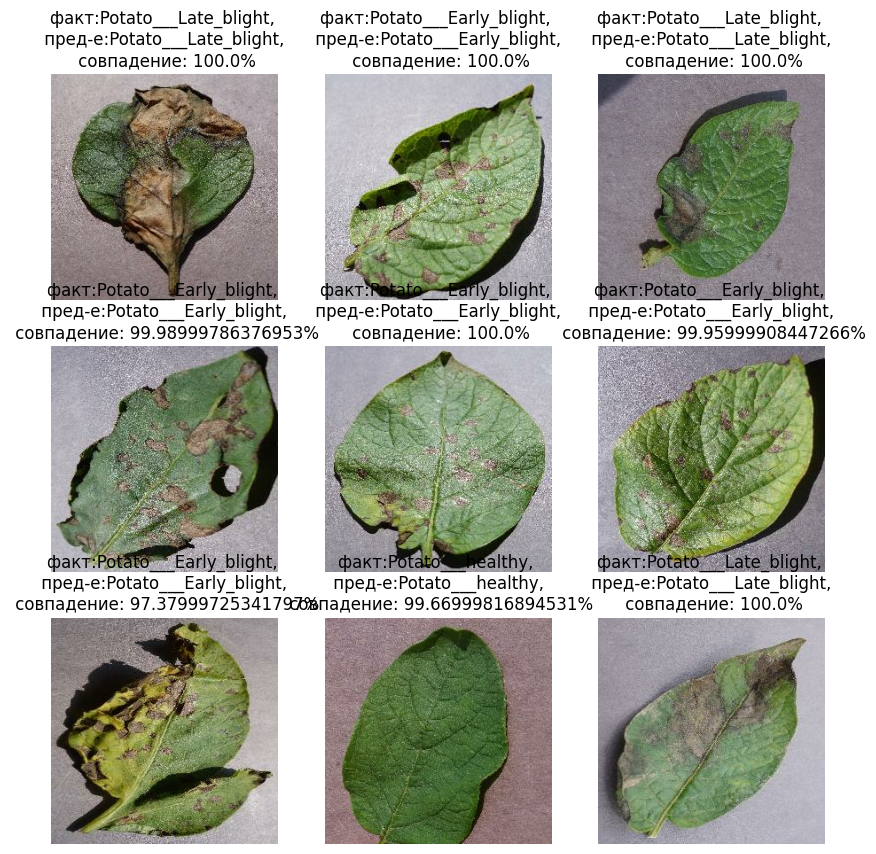

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f'факт:{actual_class}, \n пред-е:{predicted_class}, \n совпадение: {confidence}%')
        
        plt.axis('off')

In [30]:
#model.save('data/model_potatos_val_25.keras')

In [31]:
loaded_model = keras.saving.load_model('data/model_potatos_val_25.keras')

AttributeError: module 'tensorflow.keras' has no attribute 'saving'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


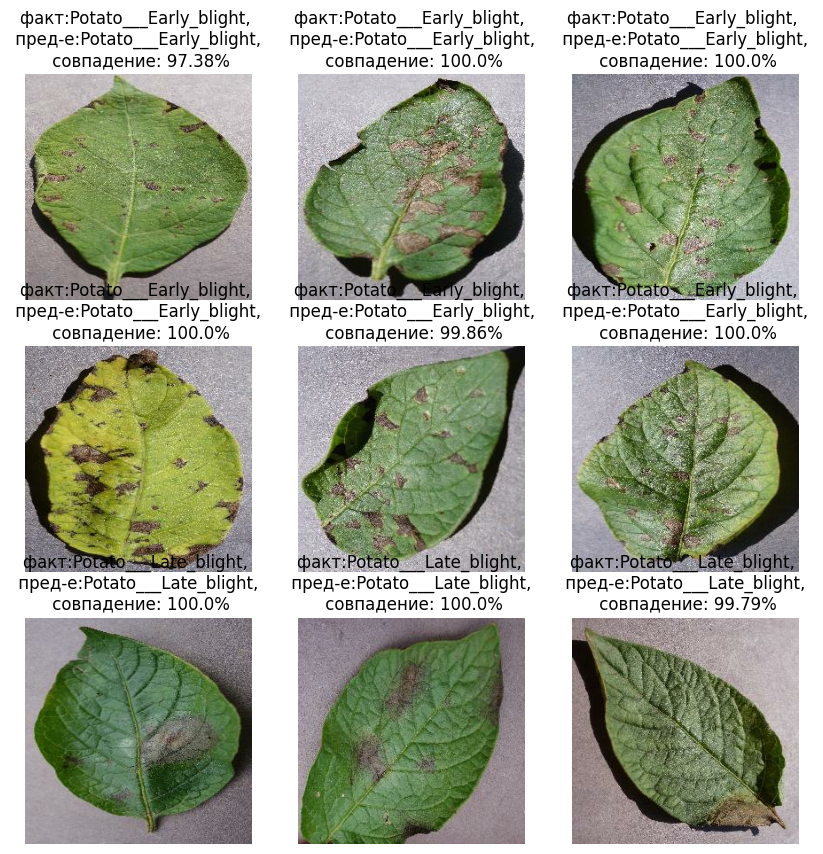

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f'факт:{actual_class}, \n пред-е:{predicted_class}, \n совпадение: {confidence}%')
        
        plt.axis('off')

In [ ]:
'''import os
model_version = max([int(i) for i in os.listdir('data/models') + [0]]) + 1

model.save(f'data/models/{model_version}/model.keras')'''